In [1]:
import warnings
import sklearn.metrics as metrics
from utility import split_sequence,plot_history
from dataset import suny_international
from animate import plot_daily
import tensorflow as tf

In [2]:
warnings.filterwarnings("ignore")
tf.get_logger().setLevel('ERROR')

In [3]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 5]

In [4]:
import numpy as np
from keras.models import Sequential,Model
from keras.layers import LSTM
from keras.layers import Dense,Input

Using TensorFlow backend.


In [5]:
def vanilla_lstm(n_steps, n_features):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

In [6]:
n_steps=20
n_forward=6
n_features= 1

In [7]:
df=suny_international.load_data()
df_train,df_test = suny_international.train_test_split(df)

In [8]:
X, y = split_sequence(df_train['GHI'], n_steps,n_forward)
X = X.reshape((X.shape[0], X.shape[1], n_features))
X_val, y_val = split_sequence(df_test['GHI'], n_steps,n_forward)
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], n_features))

In [9]:
history ={}

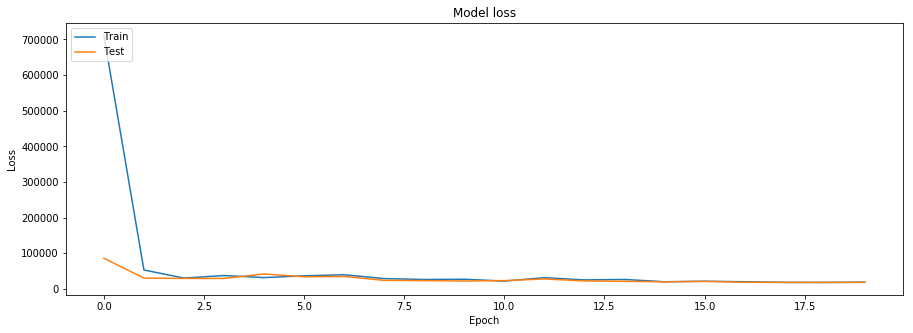

18226.741289587204


In [10]:
model=vanilla_lstm(n_steps, n_features)
history['simple_rnn']=model.fit(X,y, validation_data=(X_val,y_val),epochs=20,verbose=False)
model.save('models/simple_rnn.h5')
plot_history(history['simple_rnn'])
print(history['simple_rnn'].history['val_loss'][-1])

In [10]:
from keras.layers import concatenate

def lstm_with_weather(n_steps, n_features):
    temporal_input = Input(shape=(n_steps,1))
    lstm  = LSTM(50, activation='relu')(temporal_input)
    non_temporal_input =Input(shape=(n_features,))
    dense1 = Dense(units=20, activation='relu')(non_temporal_input) 
    all_info = concatenate(inputs=[lstm, dense1])
    dense3 = Dense(units=10, activation='relu')(all_info)
    output = Dense(units=1)(dense3)
    model = Model([temporal_input, non_temporal_input], output)
    model.compile(optimizer='adam', loss='mse')
    return model

In [11]:
n_features= len(suny_international.atmospheric_factors)

In [12]:
X_nontemporal=np.array([*(df_train[factor] for factor in suny_international.atmospheric_factors)]).T
X_nontemporal=X_nontemporal[n_steps:]
X_temporal, y = split_sequence(df_train['GHI'], n_steps)
X_temporal = X_temporal.reshape((X_temporal.shape[0], X_temporal.shape[1], 1))
X=[X_temporal,X_nontemporal]

X_nontemporal_val=np.array([*(df_test[factor] for factor in suny_international.atmospheric_factors)]).T
X_nontemporal_val=X_nontemporal_val[n_steps:]
X_temporal_val, y_val = split_sequence(df_test['GHI'], n_steps)
X_temporal_val = X_temporal_val.reshape((X_temporal_val.shape[0], X_temporal_val.shape[1], 1))
X_val=[X_temporal_val,X_nontemporal_val]

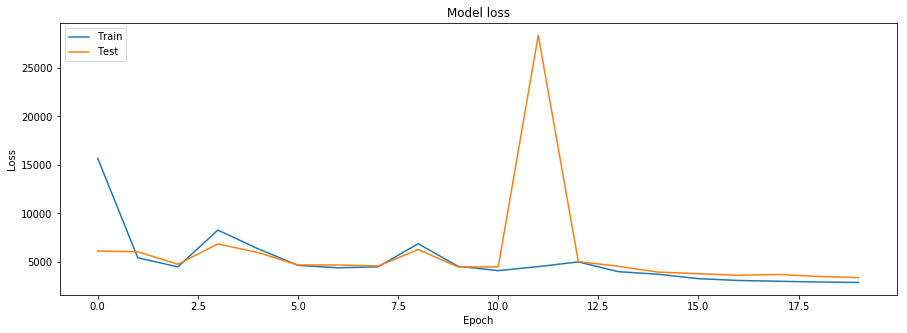

3377.534185297503


In [13]:
model=lstm_with_weather(n_steps,n_features)
history['simple_rnn_atmospheric']=model.fit(X,y, validation_data=(X_val,y_val),epochs=20,verbose=False)
model.save('models/simple_rnn_atmospheric.h5')
plot_history(history['simple_rnn_atmospheric'])
print(history['simple_rnn_atmospheric'].history['val_loss'][-1])